<a href="https://colab.research.google.com/github/GeoLinkCoding/EarthResources_DataScience/blob/main/Regression/Notebooks/Regression_FinalPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Final Pass

### Introduction

In this project, we'll predict river discharge rates at one site using the rates of upstream sites and seasonal variables. We use three sites in total with one at the Elm Fork of the Trinity River near Lewisville, TX, one at Denton Creek near Grapevine, TX which runs into Elm Fork, and the most downstream site is at Elm Fork near Carrollton, TX. Data ranges from the beginning of 2014 to the end of 2023 and discharge rates are resampled hourly. Predicting discharge rates can help city officials prepare for floods, manage water resources more efficiently, and monitor environmental impact. This project could also be used to discontinue site monitoring to save cost but retain the ability to estimate river data like discharge. With an appropriate time lag on the downstream station, discharge rates can also be predicted for some hours in the future.

### EDA

We start by retrieving the data for the three sites in the chosen time range, querying for only discharge, merging site data by time, dropping missing values, and resampling to hourly.

In [1]:
!pip install dataretrieval

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Import dataretrieval for accessing environmental data from various sources
import dataretrieval.nwis as nwis
# Trinity River
site = ['08053000', # elm fork near lewisville, tx
        '08055000', # denton creek near grapevine, tx
        '08055500'] # elm fork near carrollton, tx
# get instantaneous values (iv)
df = nwis.get_record(sites=site, service='iv', start='2014-1-01', end='2023-12-30')

# Want some metadata
df_site = nwis.get_record(sites=site, service='site')

In [3]:
df_merged = df['00060'].reset_index()  # Select the '00060' column and reset the index
df_merged = df_merged.pivot(index='datetime', columns='site_no', values='00060')  # Pivot to create site-specific columns
df_merged = df_merged.dropna()
df_resampled = df_merged.resample('h').mean()
site_names = {
        '08053000': 'Elm Fork near Lewisville',
        '08055000': 'Denton Creek near Grapevine',
        '08055500': 'Elm Fork near Carrollton'
}
df_rename = df_resampled.rename(columns=site_names)
df_rename.index = pd.to_datetime(df_rename.index)
df_rename

site_no,Elm Fork near Lewisville,Denton Creek near Grapevine,Elm Fork near Carrollton
datetime,,,
2014-01-01 06:00:00+00:00,132.75,55.050,187.25
2014-01-01 07:00:00+00:00,131.75,54.600,198.50
2014-01-01 08:00:00+00:00,129.00,53.000,198.50
2014-01-01 09:00:00+00:00,126.25,52.200,200.00
2014-01-01 10:00:00+00:00,126.75,53.000,200.00
...,...,...,...
2023-12-31 01:00:00+00:00,177.00,65.625,129.00
2023-12-31 02:00:00+00:00,177.00,67.200,129.00
2023-12-31 03:00:00+00:00,177.00,68.800,131.00


In [4]:
df_site

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,08053000,"Elm Fk Trinity Rv nr Lewisville, TX",ST,330244,965739,33.045677,-96.961117,M,F,...,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,8653-00140,POINT (-96.96112 33.04568)
1,USGS,08055000,"Denton Ck nr Grapevine, TX",ST,325913,970045,32.987068,-97.012786,M,F,...,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,8653-00140,POINT (-97.01279 32.98707)
2,USGS,08055500,"Elm Fk Trinity Rv nr Carrollton, TX",ST,325757,965639,32.965957,-96.944450,M,F,...,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,8653-00140,POINT (-96.94445 32.96596)


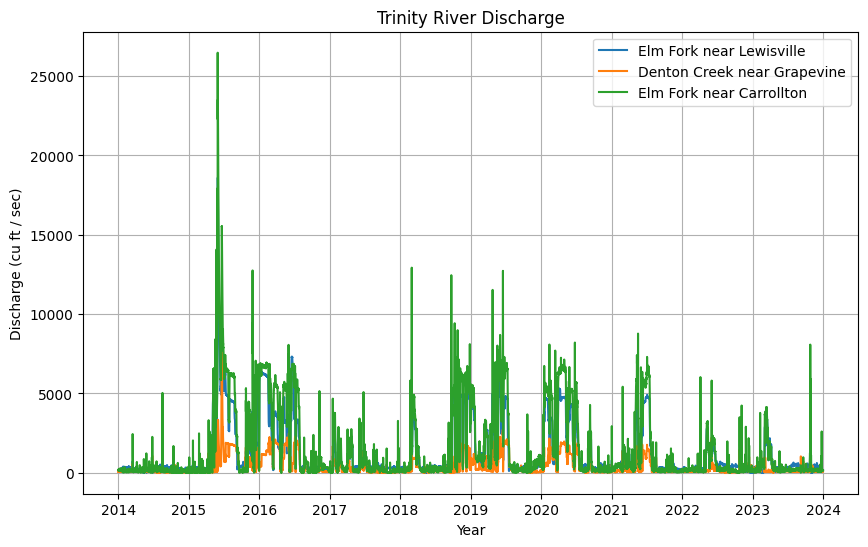

In [5]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

# Plot each site's discharge
for site_name in df_rename.columns:
    ax.plot(df_rename.index, df_rename[site_name], label=site_name)

# Set the title, labels, and grid
ax.set_title('Trinity River Discharge')
ax.set_xlabel('Year')
ax.set_ylabel('Discharge (cu ft / sec)')
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

**Figure 1.** Discharge over the whole time period. Elm Fork near Carrollton, in green, is the most downstream site and will be the y-data for this project. The other sites have smaller discharge rates but still follow a similar pattern.

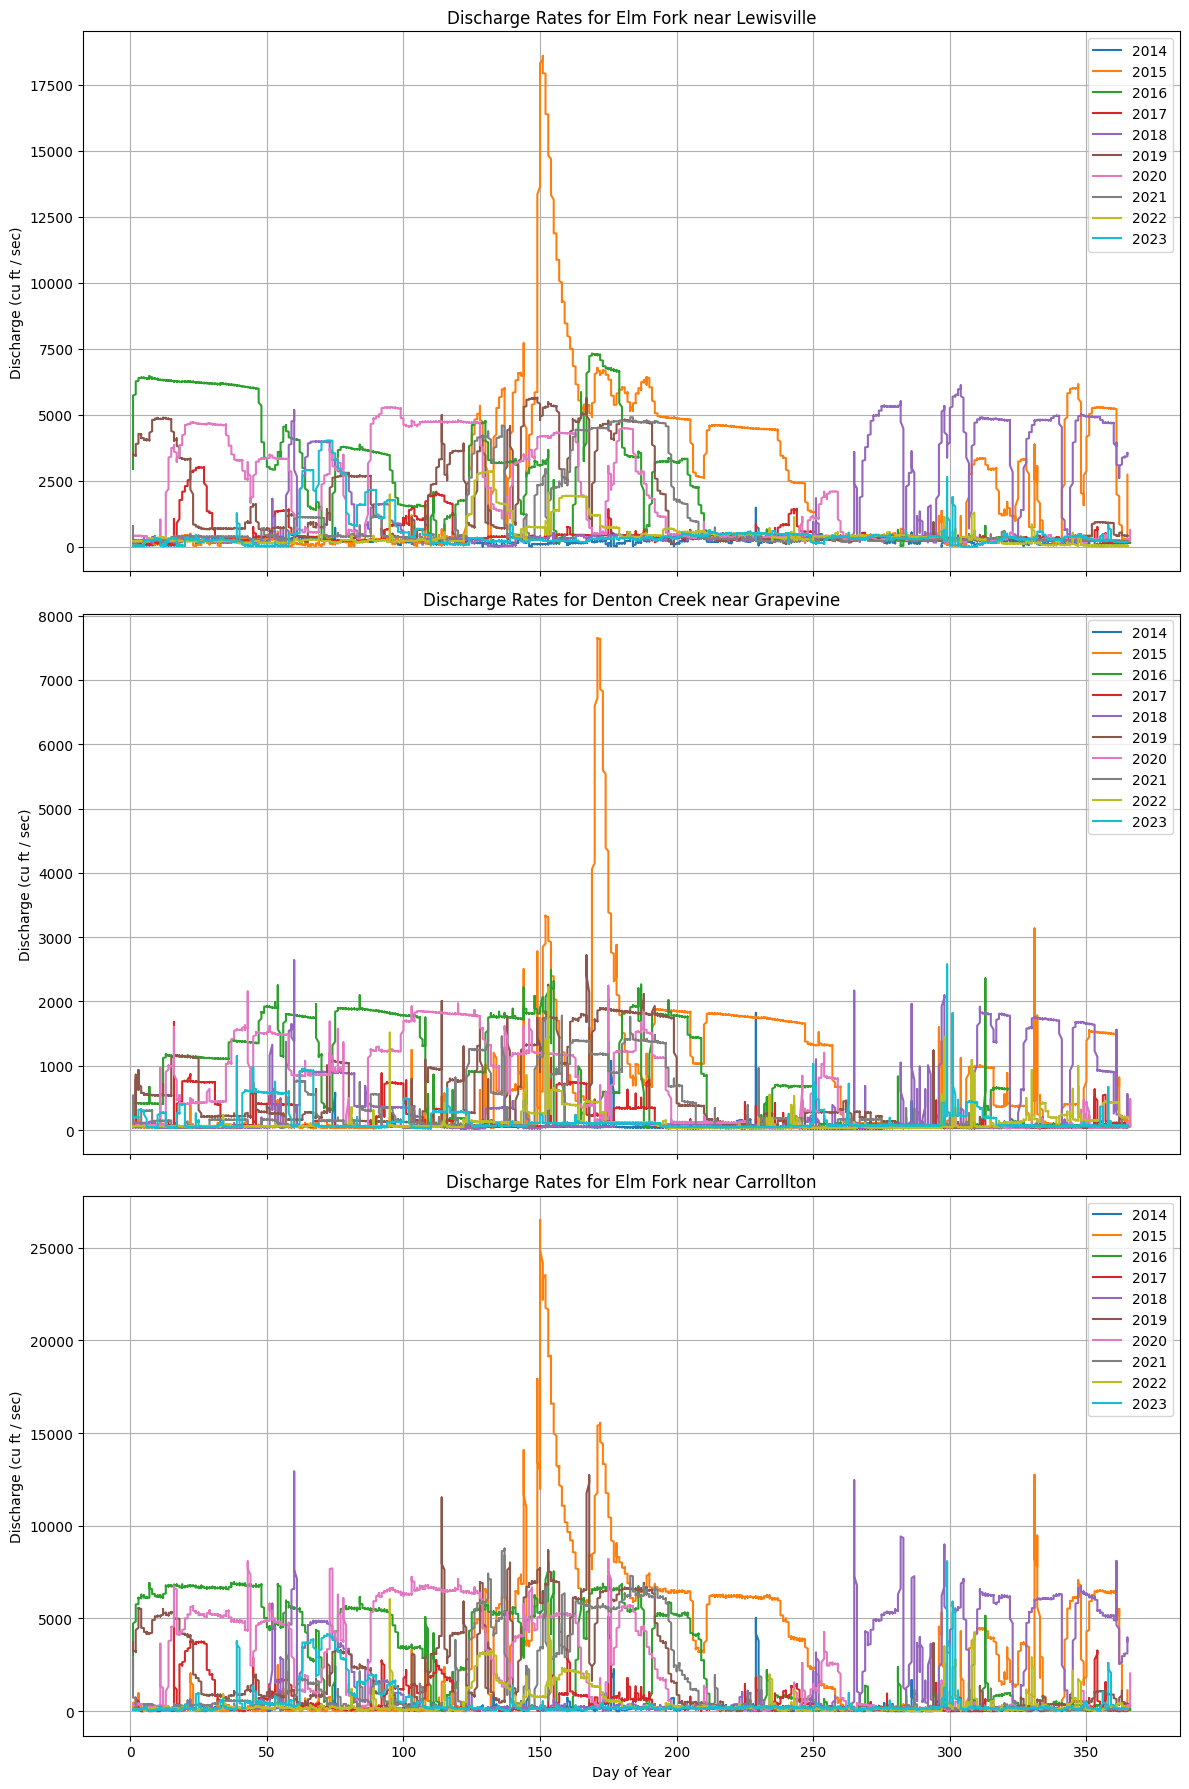

In [6]:
# Create subplots for each site
fig, axes = plt.subplots(len(df_rename.columns), 1, figsize=(12, 6 * len(df_rename.columns)), sharex=True)

# Iterate over sites and plot data
for i, site_name in enumerate(df_rename.columns):
    ax = axes[i]

    # Group by year and plot each year's data
    for year, group in df_rename.groupby(df_rename.index.year):
        ax.plot(group.index.dayofyear, group[site_name], label=year)

    ax.set_title(f'Discharge Rates for {site_name}')
    ax.set_ylabel('Discharge (cu ft / sec)')
    ax.grid(True)
    ax.legend()

# Set overall x-axis label
plt.xlabel('Day of Year')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Figure 2.** Yearly discharge for each site. There are no clear seasonal patterns for this area, unlike what may be visible in other river sites. These sites are right in the heart of DFW, Texas, a highly populous area with constant anthropogenic activity and change, so random rates aren't that surprising.

In [7]:
for site_name in df_rename.columns:
    print(f"Descriptive statistics for {site_name} Site:")
    print(f"Shape: {df_rename[[site_name]].shape}")  # Print shape
    print(df_rename[site_name].describe())
    print("\n")  # Add an empty line for better readability

Descriptive statistics for Elm Fork near Lewisville Site:
Shape: (87624, 1)
count    87423.000000
mean      1226.157164
std       1793.946669
min          0.000000
25%        253.000000
50%        359.000000
75%       1240.000000
max      18600.000000
Name: Elm Fork near Lewisville, dtype: float64


Descriptive statistics for Denton Creek near Grapevine Site:
Shape: (87624, 1)
count    87423.000000
mean       370.498137
std        586.480688
min         16.825000
25%         49.225000
50%         81.425000
75%        393.250000
max       7650.000000
Name: Denton Creek near Grapevine, dtype: float64


Descriptive statistics for Elm Fork near Carrollton Site:
Shape: (87624, 1)
count    87423.000000
mean      1487.525799
std       2360.420210
min          0.000000
25%        127.000000
50%        239.500000
75%       1722.500000
max      26475.000000
Name: Elm Fork near Carrollton, dtype: float64




There are close to 90k data points in these datasets. Discharge is small in Denton creek, but larger in the main river fork, with the downstream site being the highest.

We'll add some seasonal variables to the dataset, which aren't apparent from initial visual inspection, but could be subtle enough for an ML model to pick up.

In [8]:
def add_seasonal(df):
    df["month"] = df.index.month
    df["day_of_year"] = df.index.dayofyear
    df["hour"] = df.index.hour

    df["season"] = df["month"].map({12: "Winter", 1: "Winter", 2: "Winter",
                                3: "Spring", 4: "Spring", 5: "Spring",
                                6: "Summer", 7: "Summer", 8: "Summer",
                                9: "Fall", 10: "Fall", 11: "Fall"})
    df["season_num"] = df["season"].map({"Winter": 1, "Spring": 2, "Summer": 3, "Fall": 4})
    df = df.drop(columns=["season"])
    return df

In [9]:
df_seasonal = add_seasonal(df_rename)
df_seasonal.head()

site_no,Elm Fork near Lewisville,Denton Creek near Grapevine,Elm Fork near Carrollton,month,day_of_year,hour,season_num
datetime,,,,,,,
2014-01-01 06:00:00+00:00,132.75,55.05,187.25,1,1,6,1
2014-01-01 07:00:00+00:00,131.75,54.60,198.50,1,1,7,1
2014-01-01 08:00:00+00:00,129.00,53.00,198.50,1,1,8,1
2014-01-01 09:00:00+00:00,126.25,52.20,200.00,1,1,9,1
2014-01-01 10:00:00+00:00,126.75,53.00,200.00,1,1,10,1


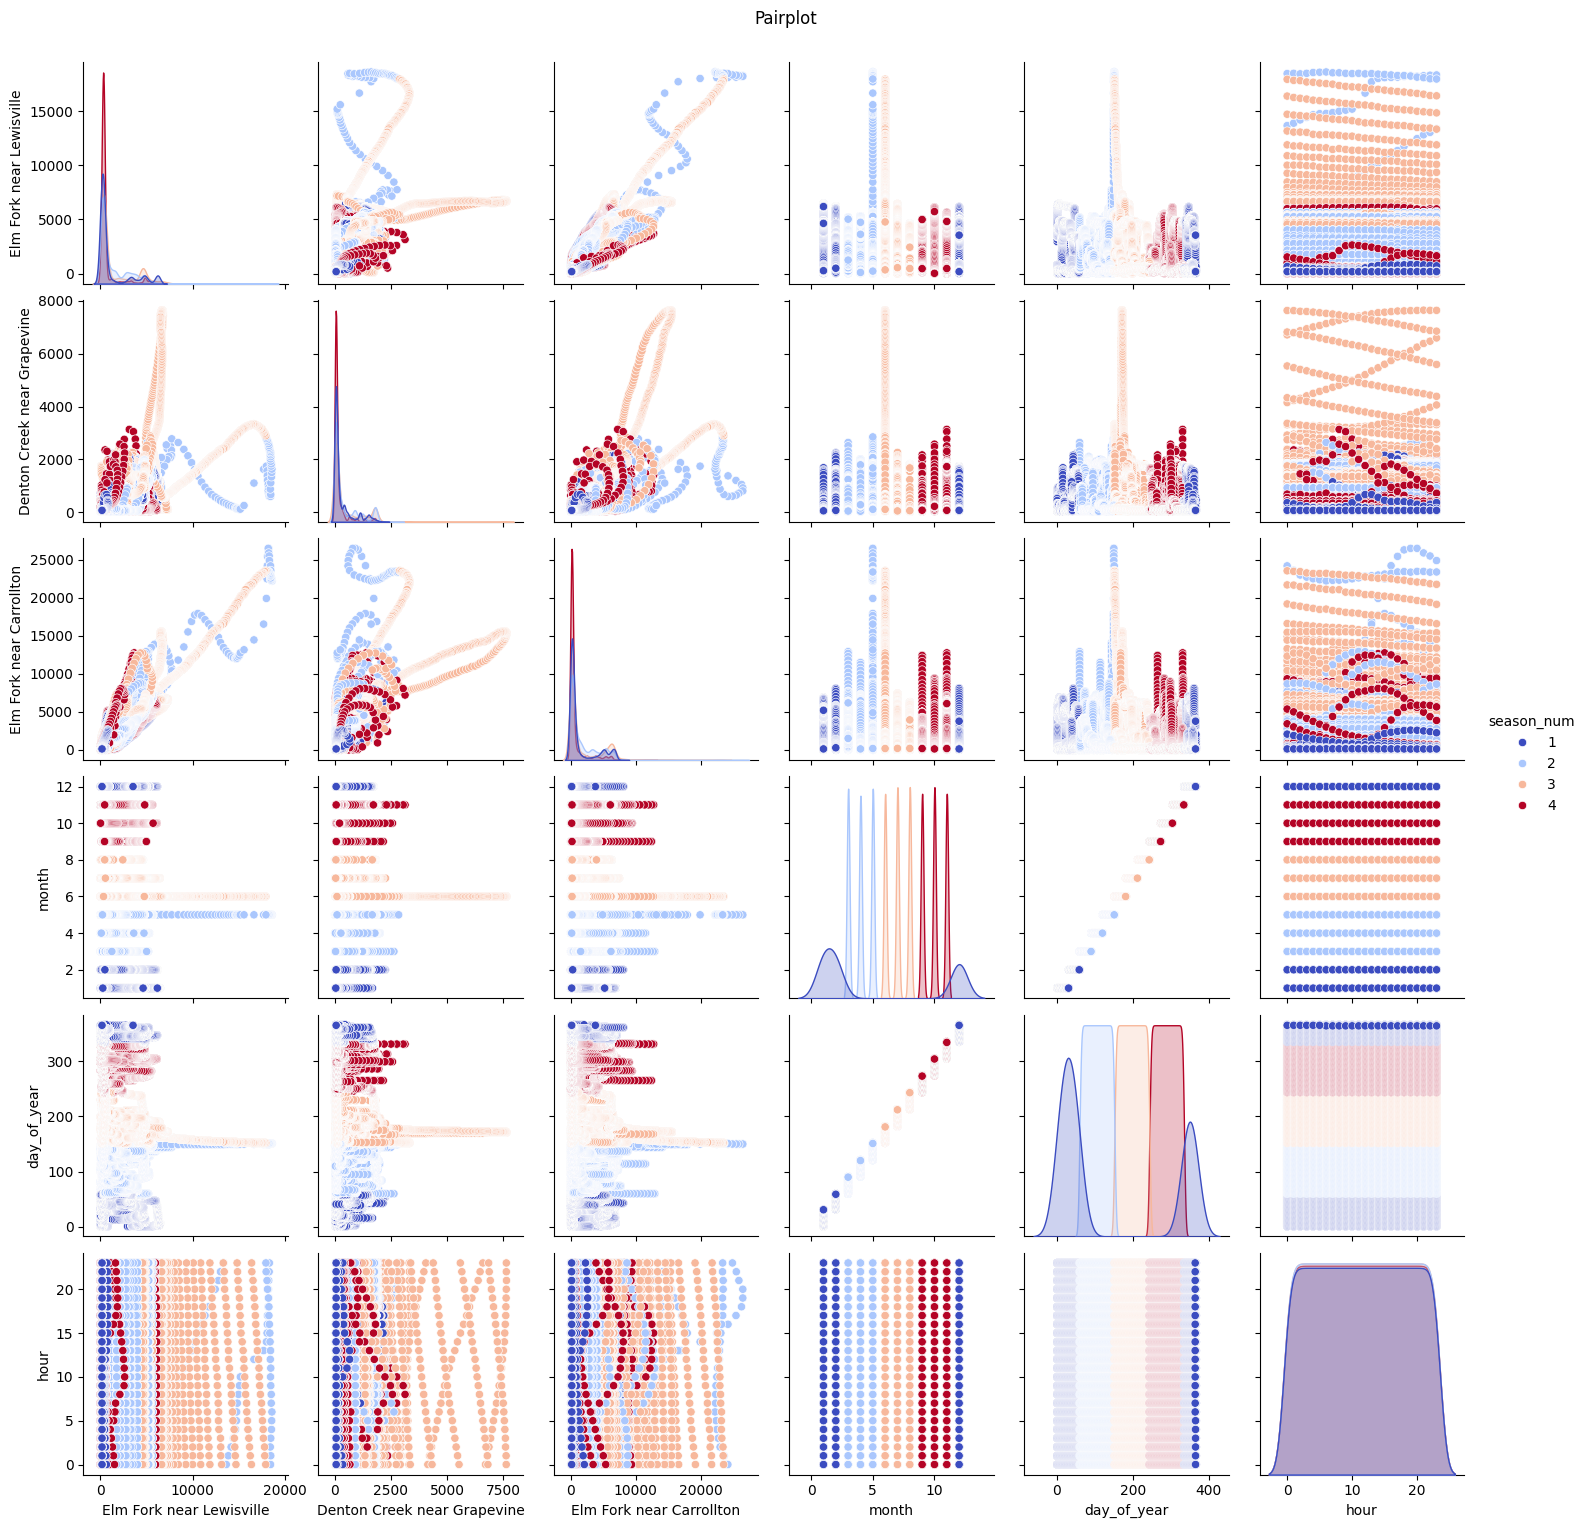

In [10]:
sns.pairplot(df_seasonal, hue="season_num", palette="coolwarm")
plt.suptitle("Pairplot", y=1.02)
plt.show()

**Figure 3.** Pairplot for each site and some seasonal features. There are some hourly variations in the data and meteorological seasons have some patterns as well.

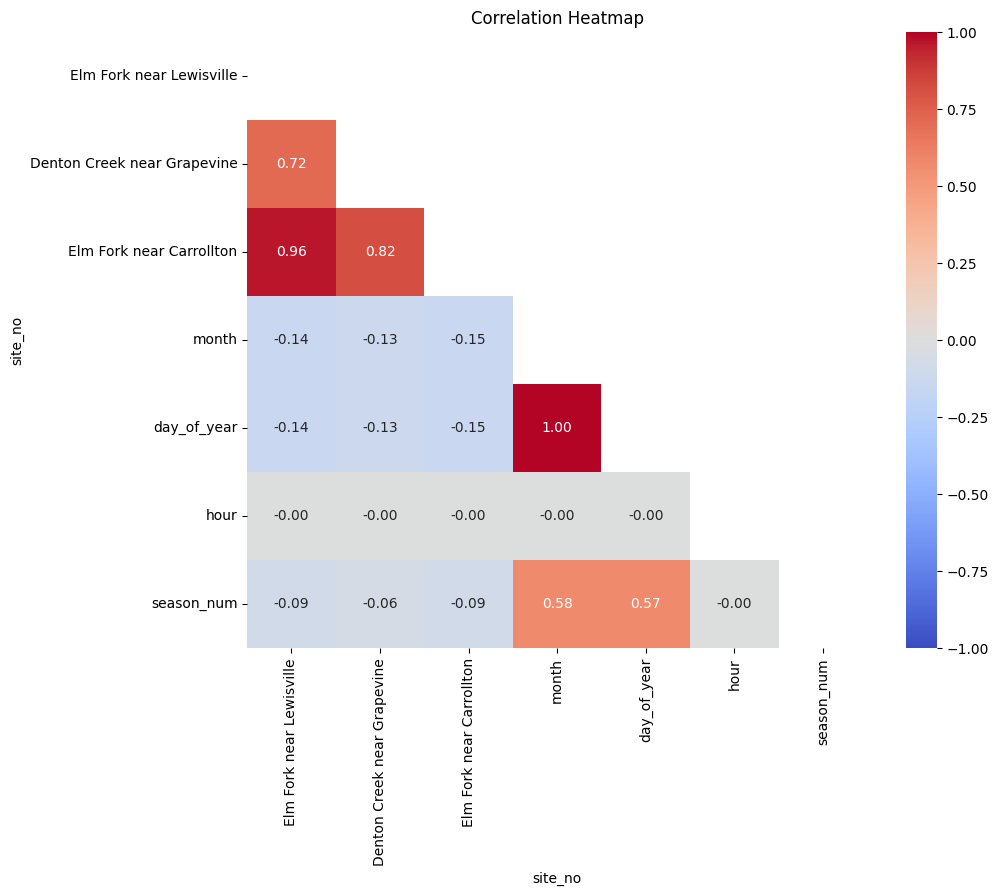

In [11]:
corr_matrix = df_seasonal.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask=mask, vmin=-1, vmax=1)

plt.title('Correlation Heatmap')
plt.show()

**Figure 4.** Correlation heatmaps for each site and seasonal features.

### Libraries

In [12]:
!pip install xgboost

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost

### Lagging

The upstream sites are a couple miles upstream from the downstream site, and since water takes time to travel through a river, a time lag can be incorporated into the downstream site to account for the time it takes new water to get there. We'll test time lags of 0 hours to 5 hours with linear regression to find the appropriate shift.

In [38]:
for i in range(0,6):
    df_lag = df_seasonal.copy()
    df_lag['Elm Fork near Carrollton'] = df_lag['Elm Fork near Carrollton'].shift(-i)
    df_lag = df_lag.dropna()
    X = df_lag.drop(columns=['Elm Fork near Carrollton'])
    y = df_lag['Elm Fork near Carrollton']

    # Split data into training and testing sets
    X_train = X[df_lag.index.year < 2022]
    X_test = X[df_lag.index.year >= 2022]
    y_train = y[df_lag.index.year < 2022]
    y_test = y[df_lag.index.year >= 2022]

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Lag {i}: RMSE: {rmse}, R-squared: {r2}")

Lag 0: RMSE: 308.1989810521765, R-squared: 0.8404426621060725
Lag 1: RMSE: 292.28843775526377, R-squared: 0.8565026391932811
Lag 2: RMSE: 280.78131806062, R-squared: 0.8675842063804874
Lag 3: RMSE: 275.24532214544263, R-squared: 0.8727590605483121
Lag 4: RMSE: 275.6260223196621, R-squared: 0.8724109388179261
Lag 5: RMSE: 280.8680942628187, R-squared: 0.8675160853353784


A 3-hour lag found the best results according to the metrics. These metrics are explained later in the Linear Regression section. The upstream Elm Fork site is about 5.5 miles straight from the downstream. With an estimated flow rate around 2-3 mph and considering river curvature, a 3-hour lag is an expected result.

In [20]:
df_lag = df_seasonal.copy()
df_lag['Elm Fork near Carrollton'] = df_lag['Elm Fork near Carrollton'].shift(-3)
df_lag = df_lag.dropna()
df_lag.head()

site_no,Elm Fork near Lewisville,Denton Creek near Grapevine,Elm Fork near Carrollton,month,day_of_year,hour,season_num
datetime,,,,,,,
2014-01-01 06:00:00+00:00,132.75,55.05,200.00,1,1,6,1
2014-01-01 07:00:00+00:00,131.75,54.60,200.00,1,1,7,1
2014-01-01 08:00:00+00:00,129.00,53.00,183.25,1,1,8,1
2014-01-01 09:00:00+00:00,126.25,52.20,188.75,1,1,9,1
2014-01-01 10:00:00+00:00,126.75,53.00,184.50,1,1,10,1


### Splitting

Due to temporal/spatial autocorrelation, splitting cannot be done randomly. Instead, we'll take a chunk of time as the test data, in this case 2014-2021 will be used for training and 2022-2023 will be testing.

Scaling was tested for this dataset, but found no significant impact on model performance, so it was left out of this final pass.

In [21]:
df_lag.dropna(inplace=True)
X = df_lag.drop(columns=['Elm Fork near Carrollton'])
y = df_lag['Elm Fork near Carrollton']

# Split data into training and testing sets
X_train = X[df_lag.index.year < 2022]
X_test = X[df_lag.index.year >= 2022]
y_train = y[df_lag.index.year < 2022]
y_test = y[df_lag.index.year >= 2022]

### Linear Regression

Linear regression is a simple model that predicts slope and intercept for a straight line through the data. Even though it's the most basic ML model, it can still be very accurate for simpler datasets. Two scoring metrics will be used to evaluate model performance. First is R-squared, which ranges 0-1 with 1 being an exact match. R-squared measures how well the created line fits to the data, but this metric can be misleading. High R-squared can be due to overfitting and other factors so Root Mean Squared Error or RMSE is also used. RMSE measures how far off predictions are on average. Lower RMSE means better model performance.

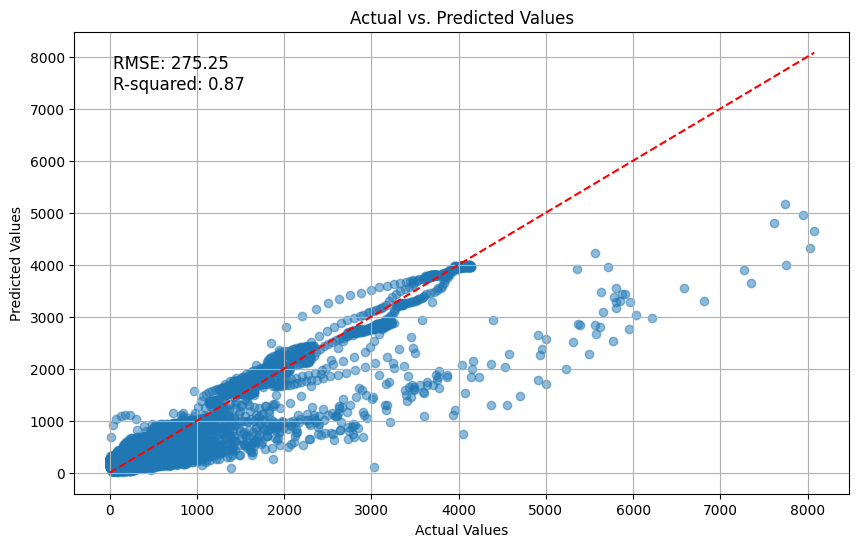

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(y_test, y_pred, alpha=0.5)  # Scatter plot with transparency
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
plt.grid(True)
textstr = f"RMSE: {rmse:.2f}\nR-squared: {r2:.2f}"
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

**Figure 5.** Linear regression actual vs predicted values with scoring metrics.

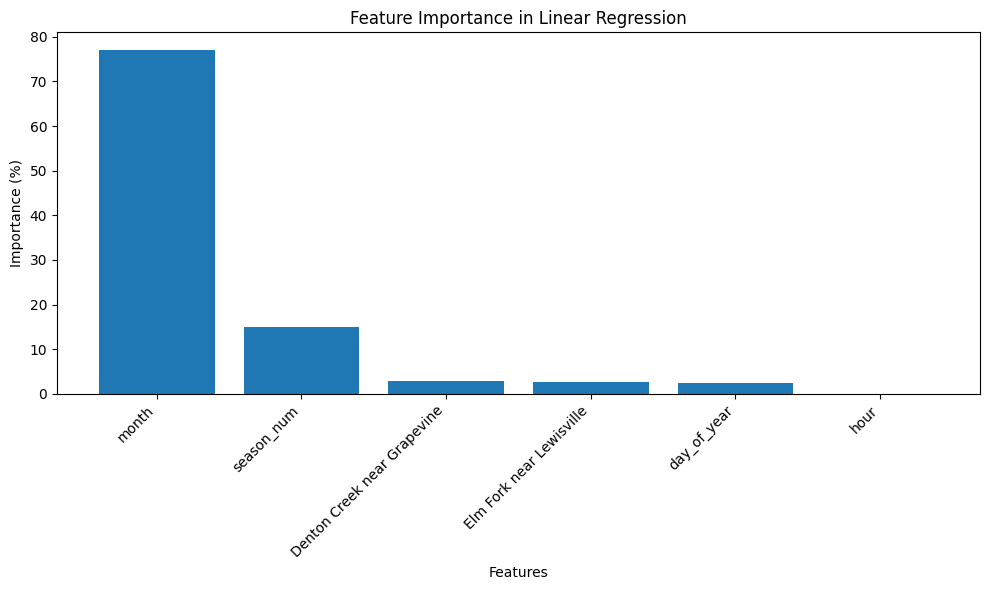

In [23]:
feature_names = X.columns
importances = np.abs(lr.coef_)

# Calculate percentage importance for each feature
importances_percent = (importances / sum(importances)) * 100

# Sort features by importance in descending order
sorted_indices = np.argsort(importances_percent)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances_percent = importances_percent[sorted_indices]

# Create a bar plot with percentage importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances_percent)
plt.xlabel("Features")
plt.ylabel("Importance (%)")
plt.title("Feature Importance in Linear Regression")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Figure 6.** The importance of each feature to the model as a percentage. Month of the year had the highest importance, so this model did pick up on some seasonal pattern. The two upstream sites had lower feature importance, but we'll see how much of a role they truly played below.

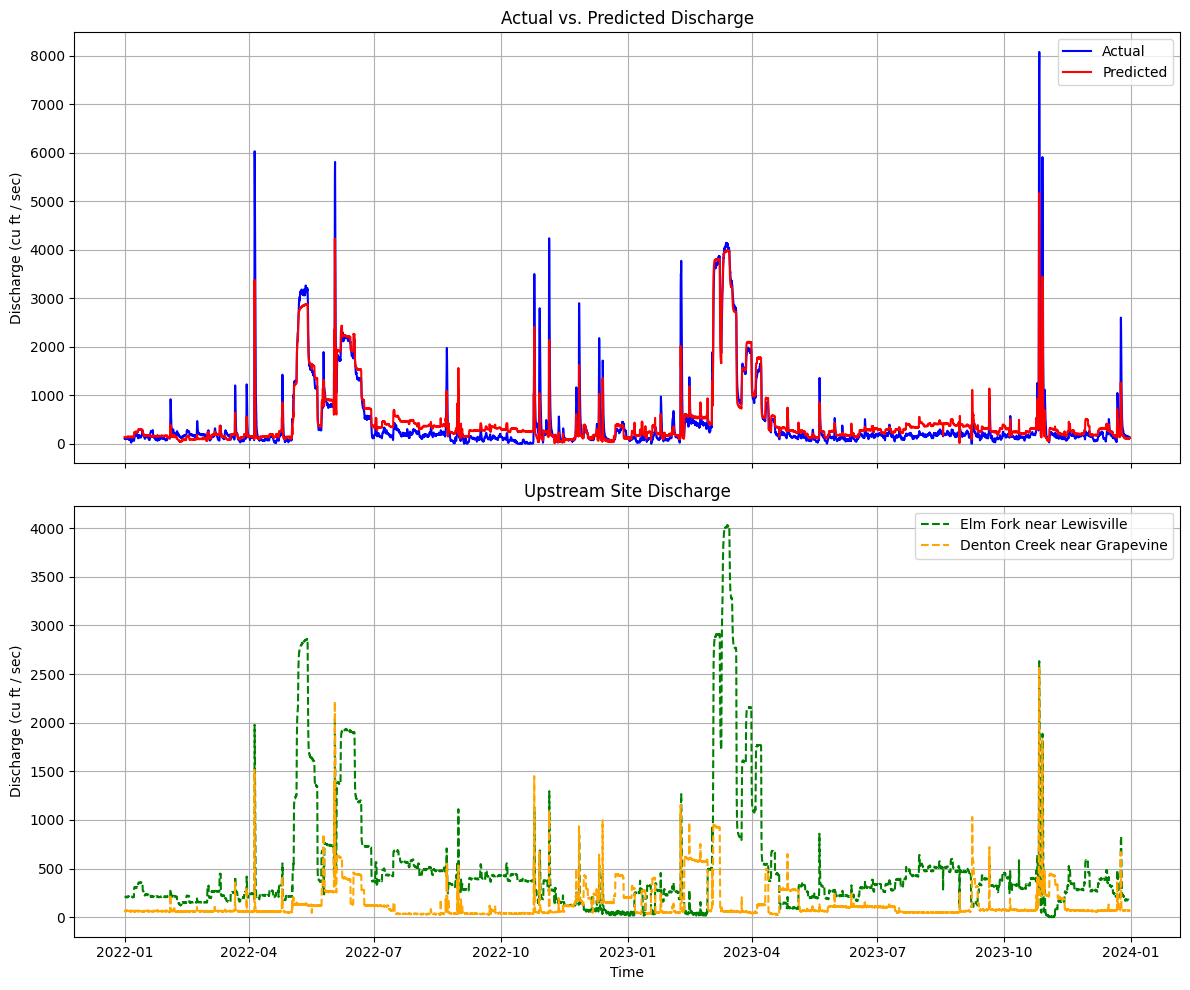

In [24]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)  # Adjust figsize as needed

# Plot actual and predicted values on the first subplot
ax1.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
ax1.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red')
ax1.set_ylabel("Discharge (cu ft / sec)")
ax1.set_title("Actual vs. Predicted Discharge")
ax1.legend()
ax1.grid(True)

# Plot upstream sites on the second subplot
ax2.plot(results_df.index, X_test['Elm Fork near Lewisville'], label='Elm Fork near Lewisville', linestyle='--', color='green')
ax2.plot(results_df.index, X_test['Denton Creek near Grapevine'], label='Denton Creek near Grapevine', linestyle='--', color='orange')
ax2.set_xlabel("Time")
ax2.set_ylabel("Discharge (cu ft / sec)")
ax2.set_title("Upstream Site Discharge")
ax2.legend()
ax2.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Figure 7.** The top plot is the actual vs predicted discharge over time and the bottom plot is the two upstream sites over the same time range. The predicted data is generally shorter than actual for quick spikes, and higher for long periods of low discharge. At first, it is tempting to think the model may have data leakage due to the similarities in peaks, but inspecting the "lower importance" upstream sites, the predictions follow their patterns quite closely. The upstream Elm Fork site is mimicked by the predicted data and instantaneous spikes from Denton Creek are mimicked as well.

### Random Forest

Random Forest is an ensemble method that uses a bagging method on multiple decision trees. Bagging works by growing trees in parallel by training on a random subset of data and features. It can perform better than Linear Regression with more complex data. It also has a set of tunable hyperparameters to help tweak model performance, though max depth is the only one we mess with here. We'll use the same scoring metrics with this model as was used in Linear Regression.

In [25]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 430.9202050975728
R-squared: 0.6881249093835502


The base hyperparameters produced less than desirable results. Tuning max depth can help fix this.

In [26]:
param_grid = {
    'max_depth': [10, 20, 30]
}
rfr = RandomForestRegressor()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',  # Use RMSE as the scoring metric
                           )

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)  # Note: RMSE is negated in scoring, so we invert it

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on test set:", rmse_test)

Best parameters: {'max_depth': 10}
Best RMSE: 835.381106535919
RMSE on test set: 346.0589372253194


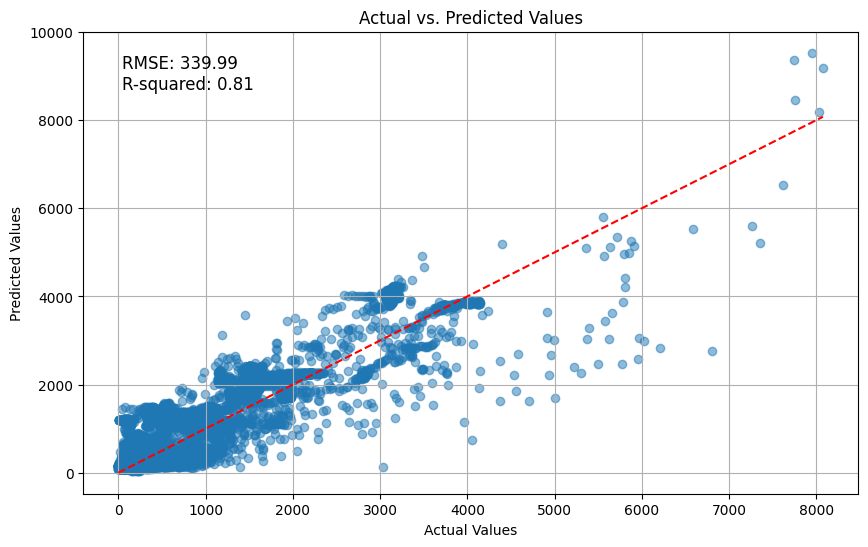

In [27]:
rfr = RandomForestRegressor(random_state=42, max_depth=10)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(y_test, y_pred, alpha=0.5)  # Scatter plot with transparency
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
plt.grid(True)
textstr = f"RMSE: {rmse:.2f}\nR-squared: {r2:.2f}"
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

**Figure 8.** Even with max depth tuned to the optimal value of 10, this model did not outperform Linear Regression. Performance is still satisfactory, but we'll evaluate below what was different.

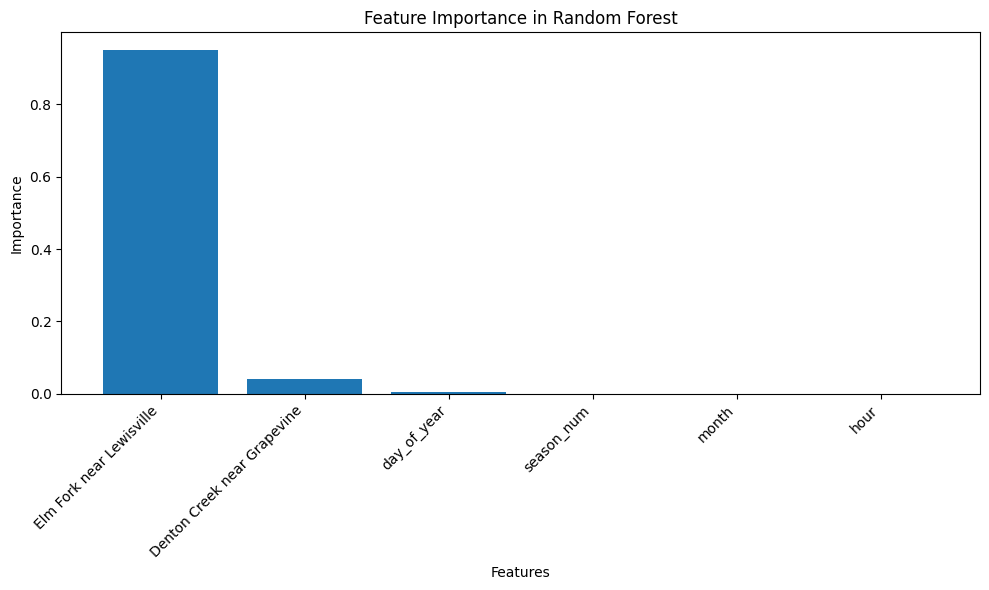

In [28]:
feature_names = X.columns
importances = rfr.feature_importances_

# Sort features by importance in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Figure 9.** Unlike Linear regression, seasonal patterns played almost no role in model predictions. Instead the upstream site in Elm Fork was the most important feature.

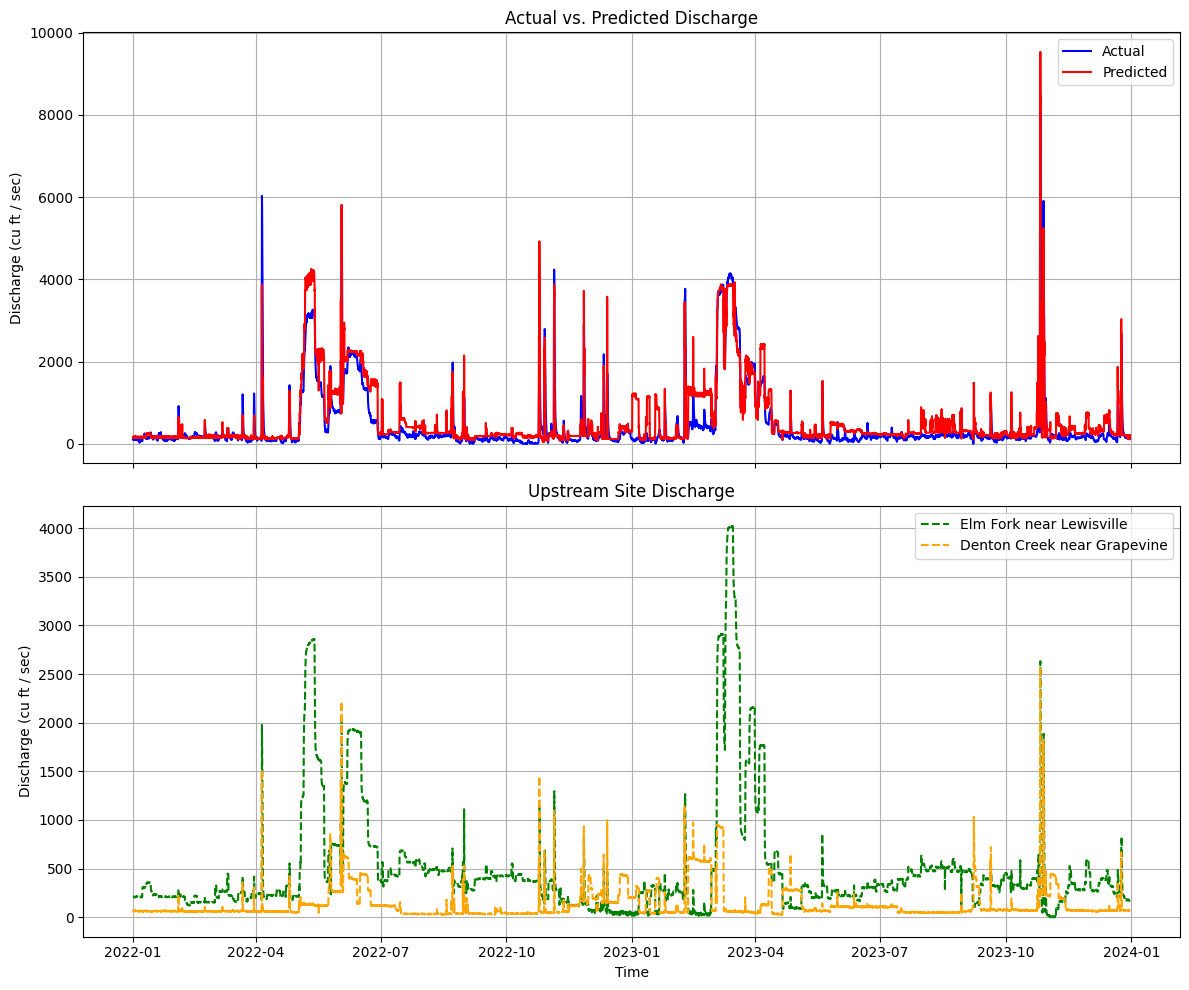

In [29]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)  # Adjust figsize as needed

# Plot actual and predicted values on the first subplot
ax1.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
ax1.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red')
ax1.set_ylabel("Discharge (cu ft / sec)")
ax1.set_title("Actual vs. Predicted Discharge")
ax1.legend()
ax1.grid(True)

# Plot upstream sites on the second subplot
ax2.plot(results_df.index, X_test['Elm Fork near Lewisville'], label='Elm Fork near Lewisville', linestyle='--', color='green')
ax2.plot(results_df.index, X_test['Denton Creek near Grapevine'], label='Denton Creek near Grapevine', linestyle='--', color='orange')
ax2.set_xlabel("Time")
ax2.set_ylabel("Discharge (cu ft / sec)")
ax2.set_title("Upstream Site Discharge")
ax2.legend()
ax2.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Figure 10.** We see the model tended to overestimate discharge rates and discharge variation in short periods.

### XG Boost

XG Boost is another ensemble method like Random Forest but with some differences. It's an advanced version of gradient boost, which uses the boosting method by building shallow trees sequentially and correcting errors of the previous tree. It also uses regularization to reduce overfitting, and does depth-wise pruning and parallel processing, among others. It is one of the more advanced and widely used ML models and can handle complex relationships very well.

In [30]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 456.8107252349999
R-squared: 0.6495229721101659


Initial model performance is even worse than Random Forest, but hyperparameter tuning may change this. We use grid search over a range of hyperparameter values to find the best ones to use.

In [31]:
param_grid = {
    'max_depth': [2, 3, 4, 5],  # Explore different tree depths
    'learning_rate': [0.01, 0.1, 0.2]  # Explore different learning rates
}
xgb_model = XGBRegressor()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',  # Use RMSE as the scoring metric
                           )

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)  # Note: RMSE is negated in scoring, so we invert it

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on test set:", rmse_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 2}
Best RMSE: 723.8747867878983
RMSE on test set: 284.4561497850954


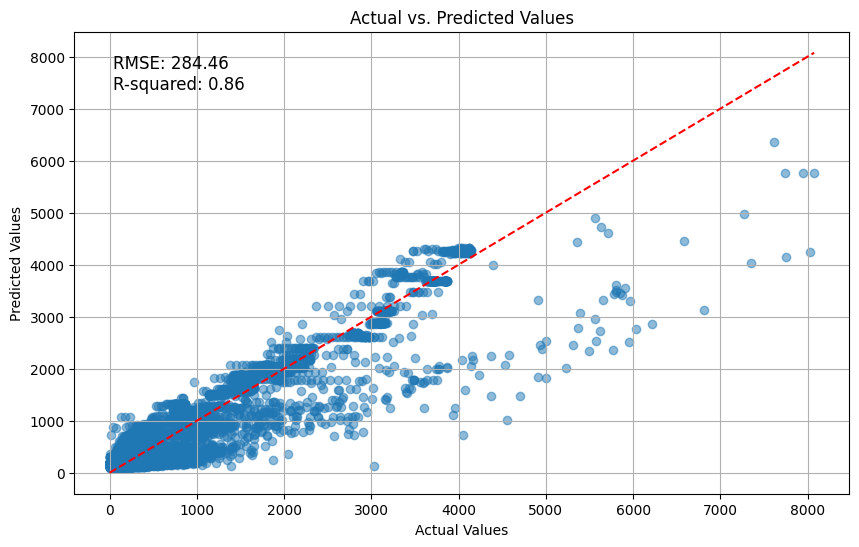

In [35]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=2, random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(y_test, y_pred, alpha=0.5)  # Scatter plot with transparency
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Add a diagonal line
plt.grid(True)
textstr = f"RMSE: {rmse:.2f}\nR-squared: {r2:.2f}"
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

**Figure 11.** After tuning the model, performance almost matches Linear Regression but is still just slightly behind.

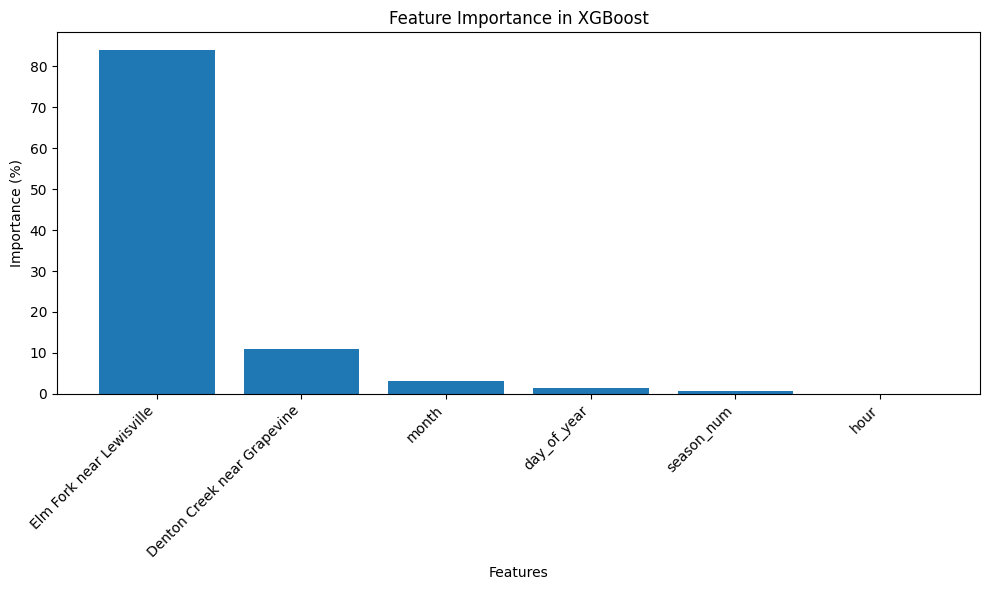

In [36]:
feature_names = X.columns
importances = xgb.feature_importances_

# Calculate percentage importance for each feature
importances_percent = (importances / sum(importances)) * 100

# Sort features by importance in descending order
sorted_indices = np.argsort(importances_percent)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances_percent = importances_percent[sorted_indices]

# Create a bar plot with percentage importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances_percent)
plt.xlabel("Features")
plt.ylabel("Importance (%)")
plt.title("Feature Importance in XGBoost")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Figure 12.** Like Random Forest, the Elm Fork upstream site is the most important feature, but some seasonal features were given slightly higher importance.

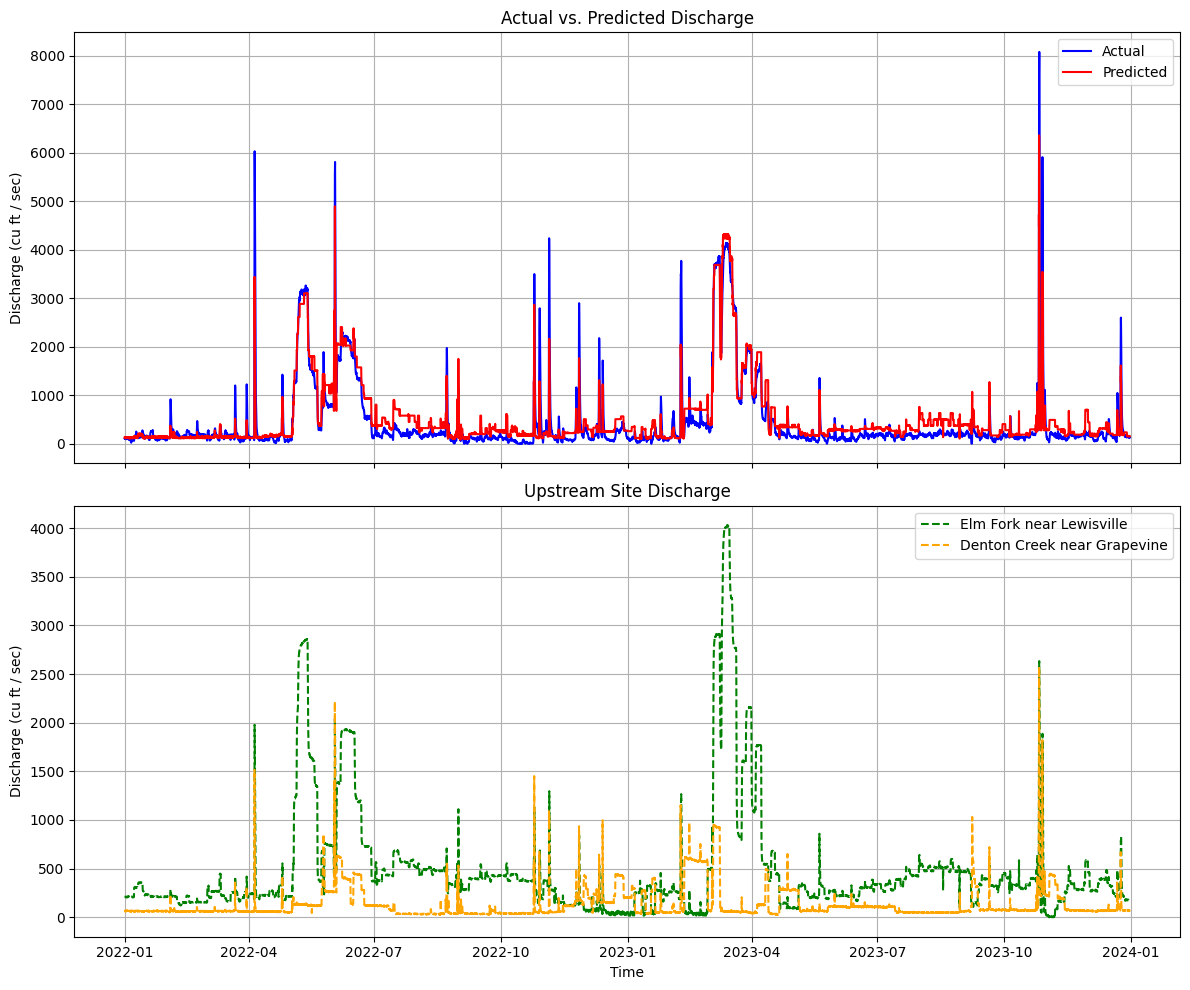

In [37]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)  # Adjust figsize as needed

# Plot actual and predicted values on the first subplot
ax1.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
ax1.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red')
ax1.set_ylabel("Discharge (cu ft / sec)")
ax1.set_title("Actual vs. Predicted Discharge")
ax1.legend()
ax1.grid(True)

# Plot upstream sites on the second subplot
ax2.plot(results_df.index, X_test['Elm Fork near Lewisville'], label='Elm Fork near Lewisville', linestyle='--', color='green')
ax2.plot(results_df.index, X_test['Denton Creek near Grapevine'], label='Denton Creek near Grapevine', linestyle='--', color='orange')
ax2.set_xlabel("Time")
ax2.set_ylabel("Discharge (cu ft / sec)")
ax2.set_title("Upstream Site Discharge")
ax2.legend()
ax2.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

**Figure 13.** Like Linear Regression, predicted instantaneous spikes are lower than actual, but the rest of the predicted is slightly higher than the actual. It is a close match but not as close as Linear Regression.

### Analysis Review

**Which method did you like the most?**

Linear Regression, surprisingly, was the best performing model. Adding a time lag helped slightly improve performance and the predicted test set aligned very closely to the true data. The relationship between upstream sites, seasonal periods, and the downstream site were clear enough for this model to outperform the others.

**Which method did you like the least?**

Random Forest was my least favorite method. Even with hyperparameter tuning, it performed the worst. It also took a lot longer to run than the other two, where grid searching took up a few minutes of computing time while the other two were almost instantaneous.

**How did you score these supervised models?**

I used R-squared and RMSE. R-squared evaluates how close the line fits the data. This method can be misleading due to possible overfitting, and low scores don't always mean poor performance, so a second metric is helpful for comparison. RMSE measures how far off predictions are on average, with lower scores indicating better performance. RMSE can be sensitive to outliers and is scale dependent, which is why having at least two scoring metrics is always beneficial.

**Did the output align with your geologic understanding?**

The output did align with my geologic understanding. As river water flows downstream, tributaries lead into the river, increasing discharge until the river flows into a dam, lake, sea, or ocean. Discharge rates in the same geographic regions will be very similar but magnitude tends to increase downstream. The downstream site shows discharge rates that are a clear combination of the upstream site in the same river and the tributary that feeds into it. A time lag to account for the travel time of new water was found to increase to performance, where the best lag found adhered to the distance between sites and the average flow rate of water. The Linear Regression model would be highly beneficial for predicting discharge rates in the future, but care should be taken to consider that spikes may be higher than the predicted values.

**What did you want to learn more about?**

I currently work for a water/wastewater company that operates with the river I evaluated, so learning how ML can apply to this industry could help me bring more value to my organization. I also wanted to learn how simple models like Linear Regression compared to advanced ones like XG Boost. It was fascinating to see that sometimes the simplest model can outperform others.

**Did you pre-process your data?**

Feature engineering was used to extract seasonal variables into the dataset, which the Linear Regression model used significantly. Scaling was tested but did not change results. A time lag was introduced to the y-data to account for water travel times. This was tested at a series of values with Linear Regression to find the best lag.

**Do all models require pre-processing?**

Yes, all models require preprocessing though not for all data. Many models can handle different types or states of data. Most machine learning models, at the very least, need data in numerical form and without null values, though other types of models may not have these requirements they will have others. Scaling is another potentially necessary component, but not all data needs to be scaled, and scalers needed can be dependent on the model used. Different splitting methods may also be needed but this is dependent on the data not the model.